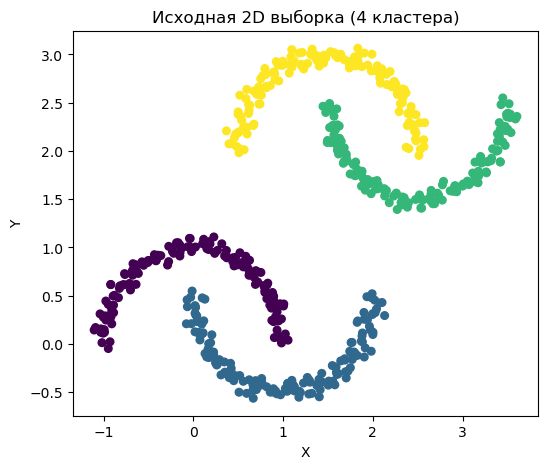

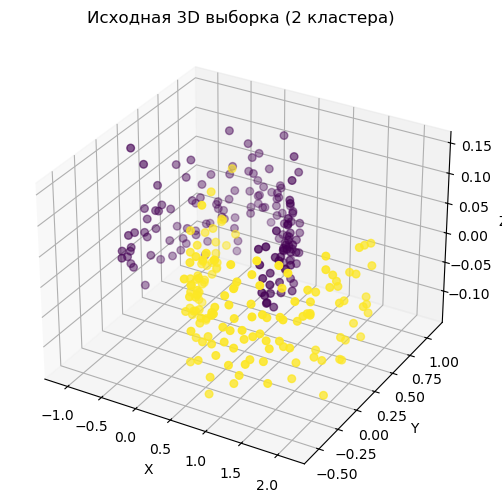

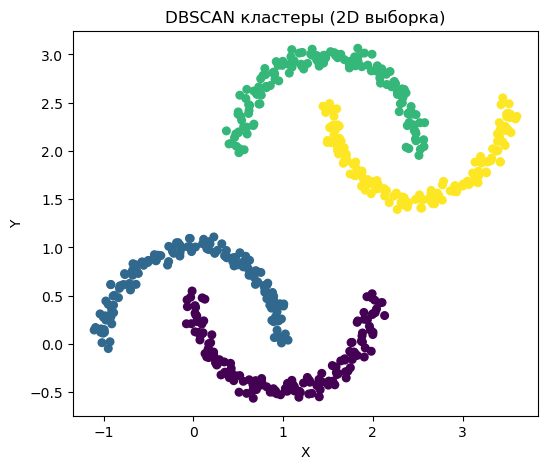

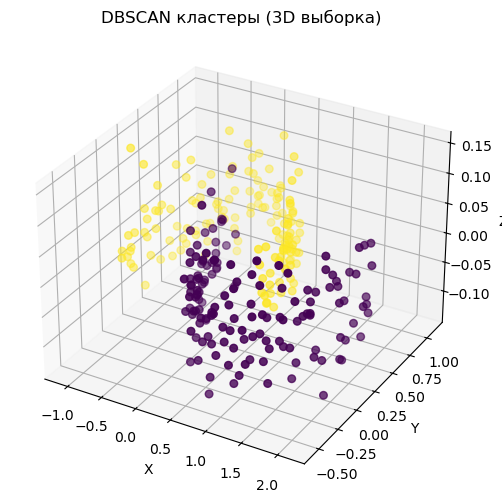

Силуэт (2D, DBSCAN): 0.3243023813207365
Силуэт (3D, DBSCAN): 0.32840652033996387


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [5]:
# %% [markdown]
# # Домашнее задание №3: Реализация DBSCAN и сравнение с KMeans
# 
# В данном ноутбуке:
# 1. Реализован алгоритм DBSCAN в виде класса.
# 2. Сгенерированы выборки: 2D (4 кластера) и 3D (2 кластера).
# 3. Проведена визуализация исходных данных и результатов кластеризации.
# 4. Оценено качество кластеризации с помощью коэффициента силуэта.
# 5. Сравнение результатов с KMeans (оптимальное число кластеров определяется методом силуэта).

# %% Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D  # Для 3D визуализации
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# %% Реализация класса DBSCAN
class DBSCAN:
    def __init__(self, eps=0.2, min_samples=5):
        """
        eps: радиус eps-окрестности.
        min_samples: минимальное число точек в eps-окрестности для формирования ядра.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        """
        Обучает модель DBSCAN на данных X.
        X: массив данных размерности (n_samples, n_features)
        """
        n_points = X.shape[0]
        # Инициализируем метки: -1 означает, что точка не принадлежит ни одному кластеру (шум)
        self.labels_ = np.full(n_points, -1)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0

        for point_idx in range(n_points):
            if not visited[point_idx]:
                visited[point_idx] = True
                neighbors = self._region_query(X, point_idx)
                if len(neighbors) < self.min_samples:
                    self.labels_[point_idx] = -1  # Шум
                else:
                    self._expand_cluster(X, point_idx, neighbors, cluster_id, visited)
                    cluster_id += 1
        return self

    def _region_query(self, X, point_idx):
        """
        Возвращает индексы точек, находящихся в eps-окрестности точки X[point_idx]
        """
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, visited):
        """
        Расширяет кластер, добавляя точки, достижимые из eps-окрестности точки.
        """
        self.labels_[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._region_query(X, neighbor_idx)
                if len(neighbor_neighbors) >= self.min_samples:
                    # Объединяем текущий список соседей с новыми соседями
                    neighbors = np.concatenate((neighbors, neighbor_neighbors))
            if self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_id
            i += 1

    def predict(self, X):
        """
        В данном случае предсказание основано на обучении, поэтому метод возвращает найденные метки кластеров.
        """
        return self.labels_

# %% Генерация 2D выборки (4 кластера)
# Используем две выборки "moons". Вторая выборка повёрнута и сдвинута для получения 4-х кластеров.
X1, y1 = make_moons(n_samples=300, noise=0.05, random_state=42)
# Поворачиваем данные второй выборки на 180 градусов и сдвигаем
theta = np.pi  # 180 градусов
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
X2 = (X1 @ R.T) + np.array([2.5, 2.5])
y2 = y1 + 2  # Новые метки: 2 и 3

# Объединяем выборки
X_2d = np.vstack((X1, X2))
y_true_2d = np.concatenate((y1, y2))

# Визуализация исходной 2D выборки
plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_true_2d, cmap='viridis', s=30)
plt.title("Исходная 2D выборка (4 кластера)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# %% Генерация 3D выборки (2 кластера)
# Используем выборку "moons" и добавляем случайное третье измерение.
X_temp, y_temp = make_moons(n_samples=300, noise=0.05, random_state=42)
# Добавляем третье измерение с небольшим шумом
z = np.random.normal(scale=0.05, size=(X_temp.shape[0], 1))
X_3d = np.hstack((X_temp, z))
y_true_3d = y_temp

# Визуализация исходной 3D выборки
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=y_true_3d, cmap='viridis', s=30)
ax.set_title("Исходная 3D выборка (2 кластера)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# %% Применение DBSCAN к 2D выборке
dbscan_2d = DBSCAN(eps=0.25, min_samples=5)
dbscan_2d.fit(X_2d)
labels_2d = dbscan_2d.labels_

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_2d, cmap='viridis', s=30)
plt.title("DBSCAN кластеры (2D выборка)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# %% Применение DBSCAN к 3D выборке
dbscan_3d = DBSCAN(eps=0.25, min_samples=5)
dbscan_3d.fit(X_3d)
labels_3d = dbscan_3d.labels_

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=labels_3d, cmap='viridis', s=30)
ax.set_title("DBSCAN кластеры (3D выборка)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# %% Оценка качества кластеризации DBSCAN (Метод силуэта)
# Для 2D выборки:
mask_2d = labels_2d != -1
if len(np.unique(labels_2d[mask_2d])) > 1:
    sil_2d = silhouette_score(X_2d[mask_2d], labels_2d[mask_2d])
    print("Силуэт (2D, DBSCAN):", sil_2d)
else:
    print("Недостаточно кластеров для расчёта силуэта (2D, DBSCAN)")

# Для 3D выборки:
mask_3d = labels_3d != -1
if len(np.unique(labels_3d[mask_3d])) > 1:
    sil_3d = silhouette_score(X_3d[mask_3d], labels_3d[mask_3d])
    print("Силуэт (3D, DBSCAN):", sil_3d)
else:
    print("Недостаточно кластеров для расчёта силуэта (3D, DBSCAN)")

# %% Сравнение с KMeans (на примере 2D выборки)
sil_scores = []
k_values = range(2, 7)  # Пробуем от 2 до 6 кластеров
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_kmeans = kmeans.fit_predict(X_2d)
    score = silhouette_score(X_2d, labels_kmeans)
    sil_scores.append(score)

optimal_k = k_values[np.argmax(sil_scores)]
print("Оптимальное число кластеров (KMeans, 2D):", optimal_k)

# Применяем KMeans с оптимальным числом кластеров
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans_opt = kmeans_opt.fit_predict(X_2d)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_kmeans_opt, cmap='viridis', s=30)
plt.title(f"KMeans кластеры (2D выборка), k = {optimal_k}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

score_kmeans = silhouette_score(X_2d, labels_kmeans_opt)
print("Силуэт (2D, KMeans):", score_kmeans)
